<a href="https://colab.research.google.com/github/elisabethelen/cobaduluaja/blob/main/semogaberhasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================= 1. Import Necessary Libraries =================
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import random

In [2]:
# ================= 2. Mount Google Drive =================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ganti path berikut ke lokasi folder dataset Anda
root_dir = '/content/drive/MyDrive/dataset'

In [4]:
# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Directori
data_dir = "dataset"  # Sesuaikan jika beda

In [7]:
# ================= 3. Transform Data =================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [10]:
# ================= 4. Split Dataset =================
# Ganti path berikut ke lokasi folder dataset Anda
# root_dir = '/content/drive/MyDrive/dataset' # original
root_dir = '/content/drive/MyDrive/dataset'  # Assuming dataset is directly under MyDrive
data_dir = root_dir  # Update data_dir to the correct root directory

# ================= 4. Split Dataset =================
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
n_total = len(full_dataset)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - n_train - n_val

train_set, val_set, test_set = random_split(full_dataset, [n_train, n_val, n_test],
                                            generator=torch.Generator().manual_seed(seed))

# Ganti transform untuk val dan test
val_set.dataset.transform = test_transform
test_set.dataset.transform = test_transform

# Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

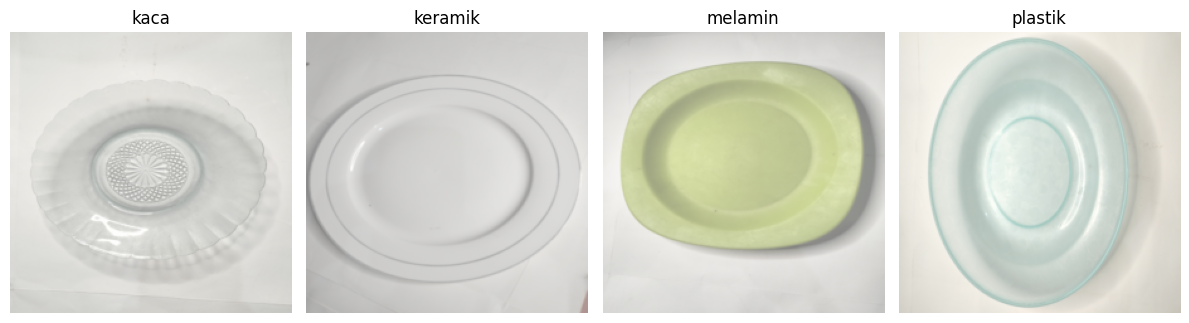

In [11]:
# ================= 5. Visualize One Image Per Class =================
def imshow(img_tensor, title):
    img = img_tensor / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Ambil satu gambar dari setiap kelas
samples = {class_name: None for class_name in class_names}

for img, label in full_dataset:
    class_label = class_names[label]
    if samples[class_label] is None:
        samples[class_label] = (img, class_label)
    if all(samples[c] is not None for c in class_names):
        break

# Tampilkan gambar-gambar yang sudah dikumpulkan
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for idx, class_name in enumerate(['kaca', 'keramik', 'melamin', 'plastik']):
    img, _ = samples[class_name]
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    axes[idx].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# ================= 6. Define Model (ResNet18) =================
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze all

# Custom classifier
num_ftrs = model.fc.in_features
num_classes = len(class_names)

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, num_classes)
)
model = model.to(device)

# Fine-tune layer4 dan fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-4)

In [17]:
# ================= 8. Training Loop =================
# Define your optimizer and criterion here
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Example using Adam optimizer
criterion = nn.CrossEntropyLoss()  # Example using CrossEntropyLoss

train_losses, val_losses, acc_list = [], [], []
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct.double() / total
    acc_list.append(train_acc.item())
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_losses[-1]:.4f} | Acc: {train_acc:.4f}")

Epoch 1/50 | Train Loss: 0.3476 | Val Loss: 0.1498 | Acc: 0.9375
Epoch 2/50 | Train Loss: 0.1981 | Val Loss: 0.0819 | Acc: 0.9667
Epoch 3/50 | Train Loss: 0.1169 | Val Loss: 0.0523 | Acc: 0.9889
Epoch 4/50 | Train Loss: 0.1226 | Val Loss: 0.0434 | Acc: 0.9750
Epoch 5/50 | Train Loss: 0.0721 | Val Loss: 0.0291 | Acc: 0.9986
Epoch 6/50 | Train Loss: 0.0511 | Val Loss: 0.0235 | Acc: 0.9986
Epoch 7/50 | Train Loss: 0.0512 | Val Loss: 0.0198 | Acc: 0.9944
Epoch 8/50 | Train Loss: 0.0521 | Val Loss: 0.0169 | Acc: 0.9958
Epoch 9/50 | Train Loss: 0.0515 | Val Loss: 0.0153 | Acc: 0.9972
Epoch 10/50 | Train Loss: 0.0339 | Val Loss: 0.0121 | Acc: 0.9972
Epoch 11/50 | Train Loss: 0.0289 | Val Loss: 0.0119 | Acc: 0.9972
Epoch 12/50 | Train Loss: 0.0264 | Val Loss: 0.0093 | Acc: 0.9972
Epoch 13/50 | Train Loss: 0.0295 | Val Loss: 0.0079 | Acc: 0.9986
Epoch 14/50 | Train Loss: 0.0297 | Val Loss: 0.0069 | Acc: 0.9986
Epoch 15/50 | Train Loss: 0.0282 | Val Loss: 0.0068 | Acc: 0.9972
Epoch 16/50 | Train

              precision    recall  f1-score   support

        kaca       1.00      1.00      1.00        57
     keramik       1.00      1.00      1.00        58
     melamin       1.00      1.00      1.00        60
     plastik       1.00      1.00      1.00        65

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



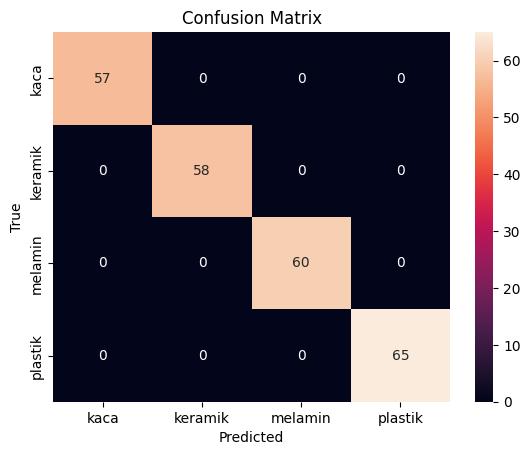

In [18]:
# ==================== 9. Model Evaluation ====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# ==================== 10. Evaluasi Test ====================
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 100.00%


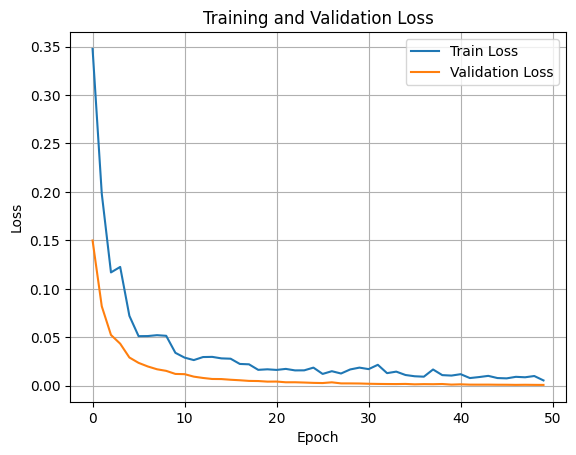

In [20]:
# ==================== 11. Visualizing Loss Curves ====================
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

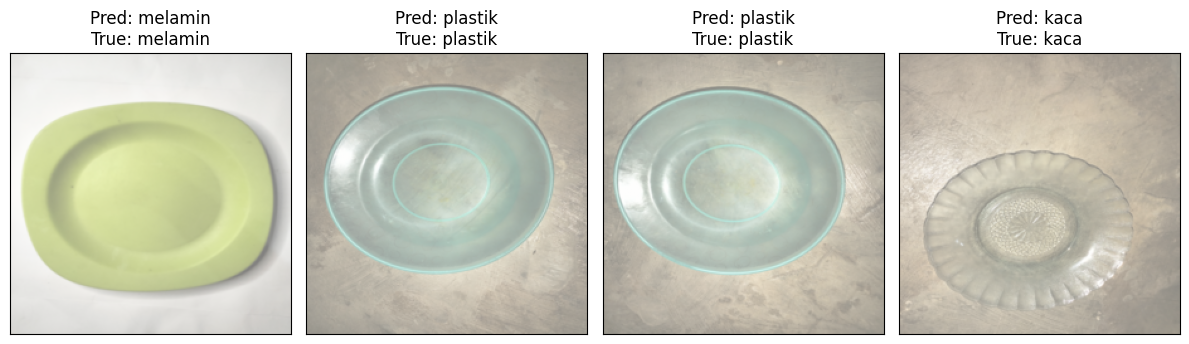

In [21]:
# ==================== 12. Predicting on Test Data ====================
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    img = inputs[idx].cpu() * 0.5 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


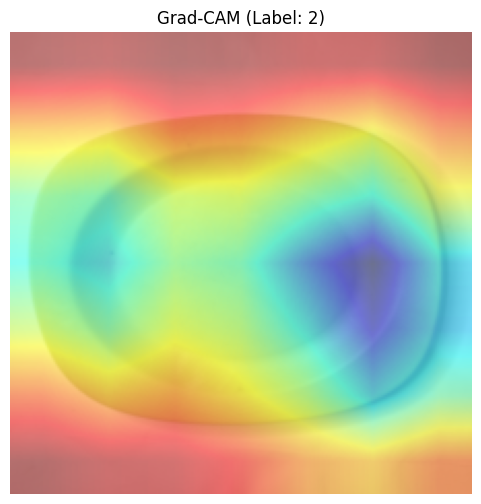

In [22]:
# ====== 13. Grad-CAM Hooks ======
features_blobs = []
gradients = []

def hook_feature(module, input, output):
    features_blobs.append(output)

def hook_gradient(module, grad_in, grad_out):
    gradients.append(grad_out[0])

# ====== Pasang Hook pada Layer Terakhir Convolution ======
final_conv = model.layer4[1].conv2
final_conv.register_forward_hook(hook_feature)
final_conv.register_backward_hook(hook_gradient)

# ====== Fungsi Generate Grad-CAM ======
import numpy as np
import cv2

def generate_gradcam(input_tensor, class_idx=None):
    model.eval()
    features_blobs.clear()
    gradients.clear()

    output = model(input_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    grads_val = gradients[0].cpu().data.numpy()
    fmap = features_blobs[0].cpu().data.numpy()

    weights = np.mean(grads_val, axis=(2, 3))[0, :]

    cam = np.zeros(fmap.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

# ====== Fungsi Visualisasi Grad-CAM ======
import matplotlib.pyplot as plt

def show_gradcam(image_tensor, cam, title='Grad-CAM'):
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5  # denormalisasi

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + image_np
    overlay = overlay / np.max(overlay)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

# ====== Contoh Pemakaian Grad-CAM dari Test Loader ======
dataiter = iter(test_loader)
images, labels = next(dataiter)

input_img = images[0].unsqueeze(0).to(device)
label = labels[0].item()

cam = generate_gradcam(input_img)
show_gradcam(images[0], cam, title=f"Grad-CAM (Label: {label})")


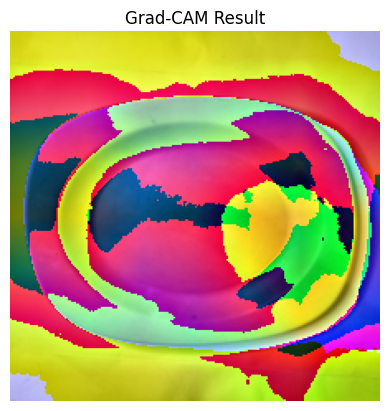

In [23]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.gradients = None
        self.activations = None
        self.target_layer = target_layer
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.unsqueeze(0).to(device)
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.cpu().numpy()

def show_gradcam(image_tensor, cam, alpha=0.5):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (224, 224))
    overlay = heatmap * alpha + image * 255
    plt.imshow(overlay.astype(np.uint8))
    plt.axis('off')
    plt.title("Grad-CAM Result")
    plt.show()

# Contoh Grad-CAM
sample_imgs, _ = next(iter(test_loader))
sample_img = sample_imgs[0].to(device)
resnet_layer = model.layer4[1].conv2
gradcam = GradCAM(model, resnet_layer)
cam = gradcam.generate_cam(sample_img)
show_gradcam(sample_imgs[0], cam)